In [134]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [136]:
df_orig=pd.read_csv('/kaggle/input/titanic/train.csv')
df_test=pd.read_csv('/kaggle/input/titanic/test.csv')
test_passengerid=df_test['PassengerId']

In [137]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def extract_features(df_in):
    df_out=df_in[:]
    df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
    df_fname=df_out['FirstName'].value_counts().to_frame().reset_index()
    df_fname.rename(columns={'count':'NameFreq'},inplace=True)
    df_out=pd.merge(df_out,df_fname,on='FirstName')

    # df['Ticket']=df['Ticket'].astype(str)
    df_tics=df_out['Ticket'].value_counts().to_frame().reset_index()
    df_tics.rename(columns={'count':'TicketFreq'},inplace=True)
    df_tics['Ticket']=df_tics['Ticket'].astype(str)
    df_out=pd.merge(df_out,df_tics,on='Ticket')

    df_out['nCabins']=df_out['Cabin'].str.split(' ',expand=True).notnull().sum(axis=1)

    df_cabins=df_out['Cabin'].value_counts().to_frame().reset_index()
    df_cabins.rename(columns={'count':'CabinFreq'},inplace=True)
    df_out=pd.merge(df_out,df_cabins,on='Cabin',how='left')
    
    df_out.drop(columns=['PassengerId','Name','FirstName','LastName','Ticket','Cabin'],inplace=True)
    return df_out

embark_map={'S':0,'C':1,'Q':2}
sex_map={'female':0,'male':1}


def logtransform(df_in,featnames):
    df_in[featnames]=np.log1p(df_in[featnames])


In [138]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, FunctionTransformer

num_cols=['Pclass','SibSp','Parch','Fare','NameFreq','TicketFreq','nCabins','CabinFreq','Age']
cat_cols=['Embarked','Sex']

num_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline=Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore',drop='first'))
])

col_transformer=ColumnTransformer(transformers=[
    ('NumericalPipeline',num_pipeline,num_cols),
    ('CategoricalPipeline',cat_pipeline,cat_cols)
], remainder='drop')



In [139]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    Int64  
 3   Age         714 non-null    float64
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    889 non-null    Int64  
 8   NameFreq    891 non-null    int64  
 9   TicketFreq  891 non-null    int64  
 10  nCabins     891 non-null    int64  
 11  CabinFreq   204 non-null    float64
dtypes: Int64(2), float64(3), int64(7)
memory usage: 85.4 KB


In [140]:

df_train=extract_features(df_orig)
df_train=df_train.replace(embark_map)
df_train=df_train.replace(sex_map)
df_train[['Embarked','Sex']]=df_train[['Embarked','Sex']].astype('Int64')
logtransform(df_train,['Fare','Age'])

X_train=df_train.drop(columns='Survived')
y_train=df_train['Survived']

X_columns=X_train.columns

X_train=col_transformer.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=col_transformer.get_feature_names_out())

X_train.head()

/tmp/ipykernel_36/248357451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
/tmp/ipykernel_36/248357451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
/tmp/ipykernel_36/3636196385.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objec

,NumericalPipeline__Pclass,NumericalPipeline__SibSp,NumericalPipeline__Parch,NumericalPipeline__Fare,NumericalPipeline__NameFreq,NumericalPipeline__TicketFreq,NumericalPipeline__nCabins,NumericalPipeline__CabinFreq,NumericalPipeline__Age,CategoricalPipeline__Embarked_1.0,CategoricalPipeline__Embarked_2.0,CategoricalPipeline__Sex_1.0
0,1.0,0.125,0.0,0.338125,0.125,0.000000,0.00,0.232026,0.688670,0.0,0.0,1.0
1,0.0,0.125,0.0,0.685892,0.000,0.000000,0.25,0.000000,0.819257,1.0,0.0,0.0
2,1.0,0.000,0.0,0.350727,0.000,0.000000,0.00,0.232026,0.728321,0.0,0.0,0.0
3,0.0,0.125,0.0,0.639463,0.125,0.166667,0.25,0.333333,0.799463,0.0,0.0,0.0
4,1.0,0.000,0.0,0.352955,0.125,0.000000,0.00,0.232026,0.799463,0.0,0.0,1.0


In [141]:
df_test=extract_features(df_test)
df_test=df_test.replace(embark_map)
df_test=df_test.replace(sex_map)
df_test[['Embarked','Sex']]=df_test[['Embarked','Sex']].astype('Int64')
logtransform(df_test,['Fare','Age'])

X_test=col_transformer.fit_transform(df_test)
X_test=pd.DataFrame(X_test,columns=col_transformer.get_feature_names_out())
X_test.head()

/tmp/ipykernel_36/248357451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
/tmp/ipykernel_36/248357451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out[['FirstName','LastName']]=df_out['Name'].str.split(',',expand=True)
/tmp/ipykernel_36/943282385.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_object

,NumericalPipeline__Pclass,NumericalPipeline__SibSp,NumericalPipeline__Parch,NumericalPipeline__Fare,NumericalPipeline__NameFreq,NumericalPipeline__TicketFreq,NumericalPipeline__nCabins,NumericalPipeline__CabinFreq,NumericalPipeline__Age,CategoricalPipeline__Embarked_1.0,CategoricalPipeline__Embarked_2.0,CategoricalPipeline__Sex_1.0
0,1.0,0.000,0.000000,0.348997,0.0,0.0,0.0,0.175824,0.815068,0.0,1.0,1.0
1,1.0,0.125,0.000000,0.333195,0.0,0.0,0.0,0.175824,0.887120,0.0,0.0,0.0
2,0.5,0.000,0.000000,0.379604,0.0,0.0,0.0,0.175824,0.952071,0.0,1.0,1.0
3,1.0,0.000,0.000000,0.363449,0.0,0.0,0.0,0.175824,0.758383,0.0,0.0,1.0
4,1.0,0.125,0.111111,0.414494,0.0,0.0,0.0,0.175824,0.711400,0.0,0.0,0.0


In [142]:
col_transformer.get_feature_names_out()

array(['NumericalPipeline__Pclass', 'NumericalPipeline__SibSp',
       'NumericalPipeline__Parch', 'NumericalPipeline__Fare',
       'NumericalPipeline__NameFreq', 'NumericalPipeline__TicketFreq',
       'NumericalPipeline__nCabins', 'NumericalPipeline__CabinFreq',
       'NumericalPipeline__Age', 'CategoricalPipeline__Embarked_1.0',
       'CategoricalPipeline__Embarked_2.0',
       'CategoricalPipeline__Sex_1.0'], dtype=object)

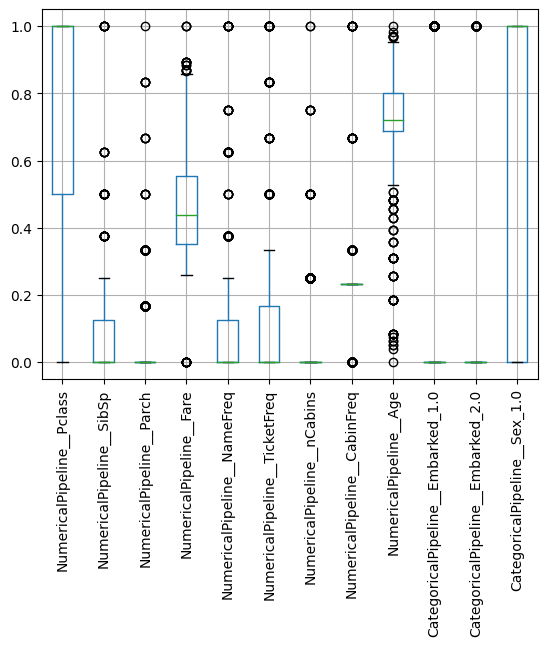

In [143]:
X_train.boxplot()
plt.xticks(rotation=90)
plt.show()

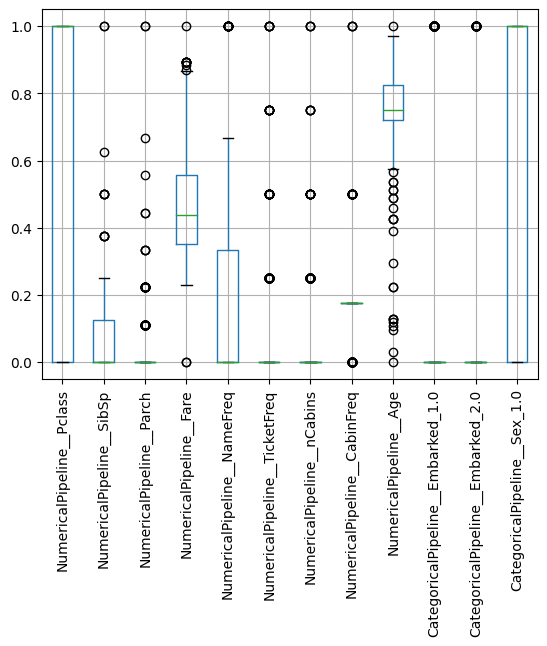

In [144]:
X_test.boxplot()
plt.xticks(rotation=90)
plt.show()

In [145]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

logreg.fit(X_train,y_train)
logreg_pred=logreg.predict(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [165]:
df_out=pd.DataFrame({'PassengerId':test_passengerid,'Survived':logreg_pred})
df_out.to_csv('/kaggle/working/gender_submissions.csv',index=False)
df_out.head()

NameError: name 'logreg_pred' is not defined

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [148]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import PowerTransformer

# class CustomLogTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self._estimator = PowerTransformer()

#     def fit(self, X, y=None):
#         X_copy = np.copy(X) + 1
#         self._estimator.fit(X_copy)

#         return self

#     def transform(self, X):
#         X_copy = np.copy(X) + 1

#         return self._estimator.transform(X_copy)

#     def inverse_transform(self, X):
#         X_reversed = self._estimator.inverse_transform(np.copy(X))

#         return X_reversed - 1